In [ ]:
# Import essential libraries
import os  # For working with file paths
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting visualizations
import rasterio  # For reading and writing raster data
from rasterio.windows import Window  # (Optional) For reading raster windows


In [ ]:
# Import GeoPandas for working with vector data (GPKG files)
import geopandas as gpd

# Set the path to the main data directory (change if necessary)
data_dir = "/content"  # Path to your main working directory

# Define paths to the necessary GPKG files
point_fn = os.path.join(data_dir, 'AOI_fix2.gpkg')  # GPKG with REE mineral data
none_points_gpkg_path = os.path.join(data_dir, 'None_points.gpkg')  # GPKG with non-AOI points

# Load mineral occurrence points from the GPKG file
df_points = gpd.read_file(point_fn)

# Filter rows where the 'Tipe' column contains 'REE' (case-insensitive)
REE_points = df_points[df_points['Tipe'].str.contains('REE', case=False, na=False)]

# Print some of the filtered REE points to verify the data
print("REE Points:")
print(REE_points.head())

# Load the None points (non-AOI) from another GPKG file
none_points = gpd.read_file(none_points_gpkg_path)

# Print some of the None points to verify the data
print("\nNone Points:")
print(none_points.head())


REE Points:
    id Tipe     X_coor     y_coor                        geometry
66   2  REE  73.926462  23.832060  MULTIPOINT (73.92646 23.83206)
67   2  REE  73.912194  23.832971  MULTIPOINT (73.91219 23.83297)
68   2  REE  73.937255  23.839750  MULTIPOINT (73.93725 23.83975)
69   2  REE  73.910946  23.761634  MULTIPOINT (73.91095 23.76163)
70   2  REE  73.895431  23.779847  MULTIPOINT (73.89543 23.77985)

None Points:
   id  Tipe  X_coor  y_coor                        geometry
0   1  None     NaN     NaN   MULTIPOINT (74.0464 24.86759)
1   1  None     NaN     NaN  MULTIPOINT (74.42795 23.53948)
2   1  None     NaN     NaN   MULTIPOINT (74.3076 23.60694)
3   1  None     NaN     NaN  MULTIPOINT (74.26659 23.52868)
4   1  None     NaN     NaN  MULTIPOINT (74.14354 23.57725)


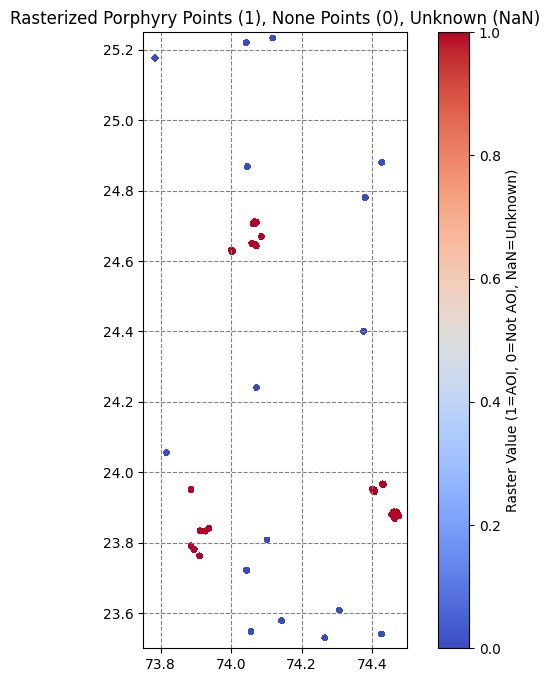

In [ ]:
# Import additional libraries needed for rasterization and plotting
from rasterio.features import rasterize  # For rasterizing vector data

# Open a reference TIFF to extract shape and metadata
with rasterio.open('/content/REE.Pr_ppm.tif') as src:
    data = src.read(1)  # Read the first band from the TIFF
    transform = src.transform  # Extract the transformation matrix
    nodata_mask = (data == src.nodata)  # Create a mask for nodata values

# Prepare shapes for rasterization: AOI as 1, Non-AOI as 0
shapes = (
    [(geom.buffer(0.01), 1.0) for geom in REE_points.geometry] +  # REE points buffered and labeled as 1
    [(geom.buffer(0.01), 0.0) for geom in none_points.geometry]   # Non-AOI points buffered and labeled as 0
)

# Rasterize the shapes to match the reference TIFF's shape and resolution
labels = rasterize(
    shapes=shapes,
    out_shape=data.shape,  # Ensure the output matches the original raster's shape
    fill=np.nan,  # Areas without points will be NaN (unknown)
    transform=transform  # Use the original raster's transformation
)

# Apply the nodata mask to the rasterized labels
labels[nodata_mask] = np.nan  # Set nodata areas to NaN

# Plot the rasterized labels to visualize the output
fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure for the plot
cax = ax.imshow(
    labels, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
    interpolation='nearest', cmap='coolwarm'  # Use 'coolwarm' colormap for better contrast
)
fig.colorbar(cax, ax=ax, label="Raster Value (1=AOI, 0=Not AOI, NaN=Unknown)")
ax.set_title('Rasterized REE Points (1), None Points (0), Unknown (NaN)')
plt.show()  # Display the plot


In [ ]:
# Define the path to save the new rasterized labels
output_tiff_path = '/content/REE_AOI_labels.tif'

# Copy metadata from the original TIFF and update it for the new file
meta = src.meta.copy()  # Copy the metadata from the original raster
meta.update({
    'count': 1,  # Only one band in the output raster
    'dtype': 'float32',  # Use float32 to handle NaN values
    'nodata': np.nan  # Specify NaN as the nodata value
})

# Save the rasterized labels to a new TIFF file
with rasterio.open(output_tiff_path, 'w', **meta) as dst:
    dst.write(labels.astype('float32'), 1)  # Write the labels to the first band

# Confirm the file has been saved
print(f"Rasterized labels saved to {output_tiff_path}")


Rasterized labels saved to /content/REE_AOI_labels.tif
